# Loss Landscape
In this notebook we plot the loss landscape of the models to see how it is efffected by the quantization.

In [1]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from copy import deepcopy
from pylab import *
import os
import sys
import torch




# import modules from JTAG model
module_path = os.path.abspath(os.path.join('../../workspace/models/jets/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import model as jet_tagger
import jet_datamodule

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import q_autoencoder as econ
import autoencoder_datamodule

import loss_landscapes
import loss_landscapes.metrics

STEPS = 50
DISTANCE = 50

/opt/conda/envs/loss_landscape/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
DATA_PATH = '/home/jovyan/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'

In [3]:
model1, emd1 = econ.load_model(DATA_PATH, 16, 0.0015625, 11, 'baseline')
model2, emd2 = econ.load_model(DATA_PATH, 16, 0.0015625, 3, 'baseline')
data_module = autoencoder_datamodule.get_data_module(DATASET_DIR, DATASET_FILE, 16)
train_loader = data_module.dataloaders()[0]



In [4]:
criterion = model1.loss
x, y = iter(train_loader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x, y)

In [5]:
loss_data_fin1 = loss_landscapes.random_plane(model1, 
                                             metric, 
                                             DISTANCE, 
                                             STEPS, 
                                             normalization='model', 
                                             deepcopy_model=False)
loss_data_fin2 = loss_landscapes.random_plane(model2, 
                                             metric, 
                                             DISTANCE, 
                                             STEPS, 
                                             normalization='model', 
                                             deepcopy_model=False)

In [ ]:
print(loss_data_fin1)

[[2.28435233e-01 2.29117855e-01 2.29761124e-01 ... 2.65116143e+00
  4.03052855e+00 5.92212725e+00]
 [2.34047607e-01 2.32784227e-01 2.32645318e-01 ... 2.30272198e+00
  3.70507932e+00 5.45285463e+00]
 [2.37096056e-01 2.36758545e-01 2.38977209e-01 ... 4.97760534e+00
  6.73884153e+00 9.34735298e+00]
 ...
 [2.58350366e+03 2.79886084e+03 3.04363940e+03 ... 3.90350293e+03
  3.90350293e+03 3.90350293e+03]
 [3.14845215e+03 3.33592212e+03 3.57005249e+03 ... 3.90350293e+03
  3.90350293e+03 3.90350293e+03]
 [3.22412939e+03 3.37471167e+03 3.60191870e+03 ... 3.90350293e+03
  3.90350293e+03 3.90350293e+03]]


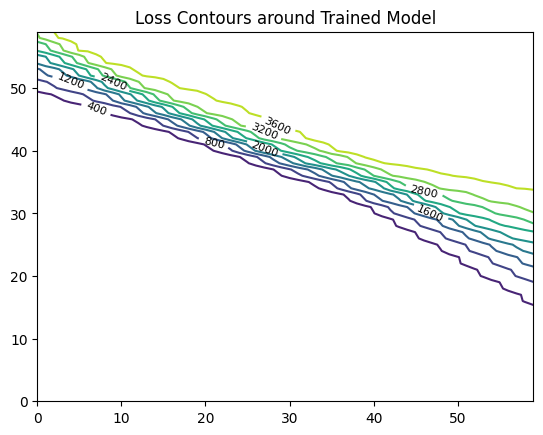

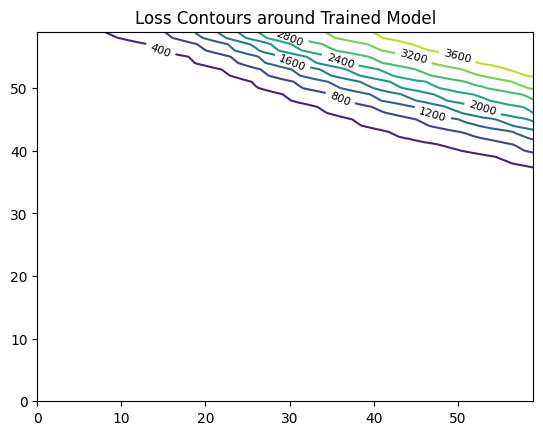

In [ ]:
plot = plt.contour(loss_data_fin1, levels=10)
plt.clabel(plot, inline=True, fontsize=8, colors='black')
plt.title('Loss Contours around Trained Model')
plt.show()

plot = plt.contour(loss_data_fin2, levels=10)
plt.clabel(plot, inline=True, fontsize=8, colors='black')
plt.title('Loss Contours around Trained Model')
plt.show()

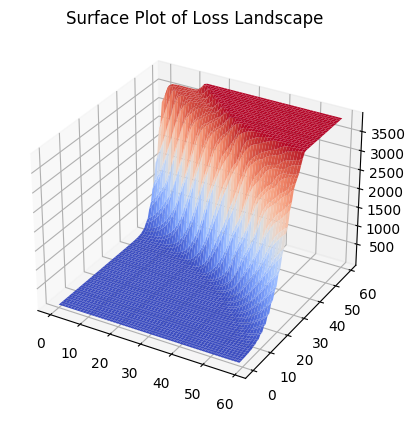

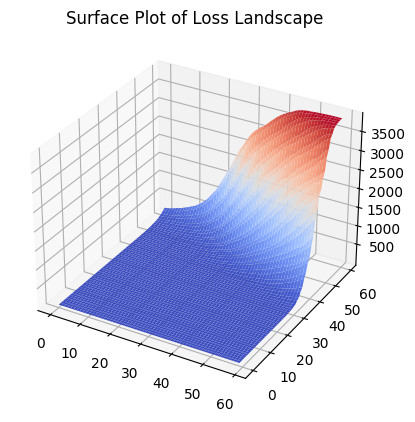

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin1, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin2, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

In [ ]:
DATA_PATH = "/home/jovyan/checkpoint/"    
DATASET_DIR = "../../data/JTAG"
DATASET_FILE = DATASET_DIR + "/processed_dataset.h5"

In [ ]:
model1, emd1 = jet_tagger.load_model(DATA_PATH, 64, 0.0125, 11)
model1, emd1 = jet_tagger.load_model(DATA_PATH, 64, 0.0125, 3)
data_module = jet_datamodule.get_data_module(DATASET_DIR, DATASET_FILE, 64)
train_loader = data_module.dataloaders()[0]

Loaded shaped data shape (train): (630000, 16)
Loaded shaped data datatype (train): float32
Loaded shaped data shape (val): (240000, 16)
Loaded shaped data datatype (val): float32


In [ ]:
criterion = model1.loss
x, y = iter(train_loader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x, y)

In [ ]:
loss_data_fin1 = loss_landscapes.random_plane(model1, 
                                             metric, 
                                             DISTANCE, 
                                             STEPS, 
                                             normalization='model', 
                                             deepcopy_model=False)
loss_data_fin2 = loss_landscapes.random_plane(model1, 
                                             metric, 
                                             DISTANCE, 
                                             STEPS, 
                                             normalization='model', 
                                             deepcopy_model=False)

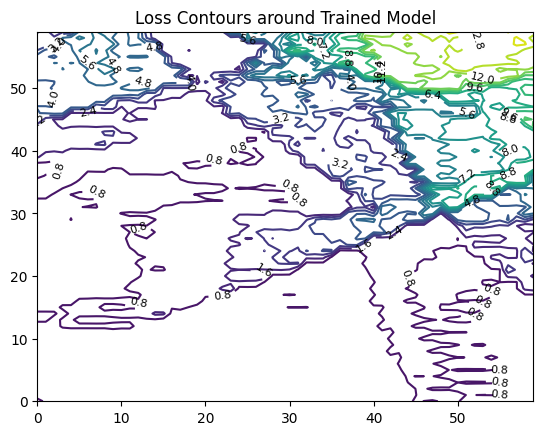

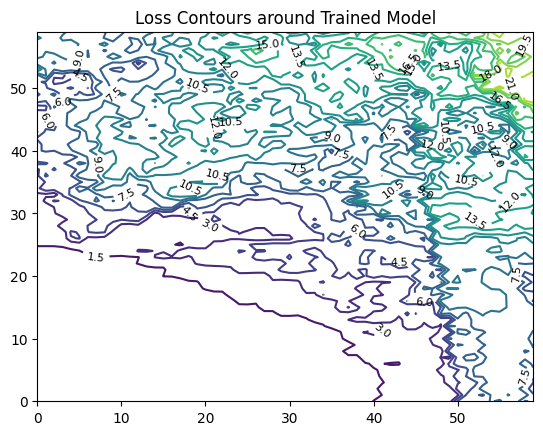

In [ ]:
plot = plt.contour(loss_data_fin1, levels=20)
plt.clabel(plot, inline=True, fontsize=8, colors='black')
plt.title('Loss Contours around Trained Model')
plt.show()
plot = plt.contour(loss_data_fin2, levels=20)
plt.clabel(plot, inline=True, fontsize=8, colors='black')
plt.title('Loss Contours around Trained Model')
plt.show()

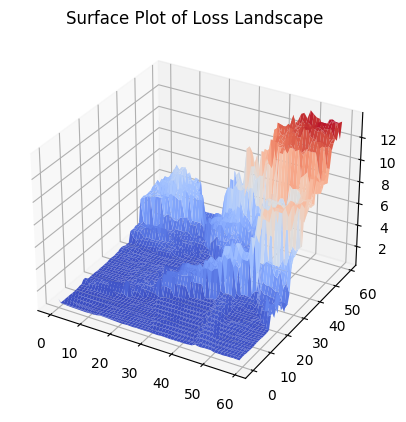

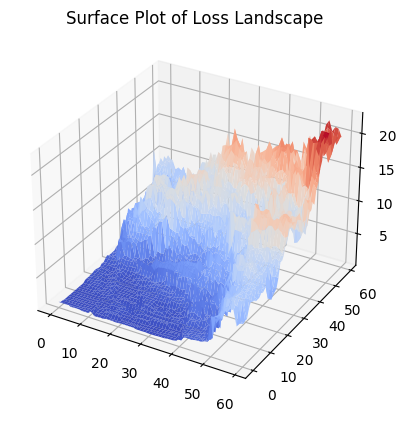

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin1, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin2, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()